In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [3]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [4]:
original_t = transforms.Compose(
    [transforms.Resize((100,100)),
     transforms.ToTensor(),
     transforms.Normalize((0.33, 0.33, 0.33), (0.33, 0.33, 0.33))])

flipped = transforms.Compose(
    [transforms.Resize((100,100)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomAffine(degrees=10, translate=(0.1,0.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.33, 0.33, 0.33), (0.33, 0.33, 0.33))])

tripped = transforms.Compose(
    [transforms.Resize((100,100)),
     transforms.RandomVerticalFlip(),
     transforms.RandomRotation(10),
     transforms.RandomAffine(degrees=10, translate=(0.1,0.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.33, 0.33, 0.33), (0.33, 0.33, 0.33))])

skipped = transforms.Compose(
    [transforms.Resize((100,100)),
     transforms.RandomPosterize(bits=2),
     transforms.ColorJitter(brightness=0.9, contrast=0.5),
     transforms.RandomAdjustSharpness(sharpness_factor=3),
     transforms.ToTensor(),
     transforms.Normalize((0.33, 0.33, 0.33), (0.33, 0.33, 0.33))])


In [5]:
hipped = transforms.Compose(
    [transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
     transforms.Resize((100,100)),
     transforms.ToTensor(),
     transforms.Normalize((0.33, 0.33, 0.33), (0.33, 0.33, 0.33))])

dipped = transforms.Compose(
    [transforms.Resize((100,100)),
     transforms.RandomEqualize(),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     transforms.Normalize((0.33, 0.33, 0.33), (0.33, 0.33, 0.33))])

In [6]:
batch_size = 8

main_dir = '../input/flowers-recognition/flowers/'

original = ImageFolder(main_dir, transform=original_t)

train_set, dev_set = train_test_split(original, test_size=0.2, shuffle=True, random_state=54)

train_set, test_set = train_test_split(original, test_size=0.25, shuffle=True, random_state=47)
#batch_size = len(test)

f_set=torchvision.datasets.ImageFolder(root=main_dir, transform=flipped)
t_set=torchvision.datasets.ImageFolder(root=main_dir, transform=tripped)
s_set=torchvision.datasets.ImageFolder(root=main_dir, transform=skipped)
h_set=torchvision.datasets.ImageFolder(root=main_dir, transform=hipped)
d_set=torchvision.datasets.ImageFolder(root=main_dir, transform=dipped)

train_set = ConcatDataset([train_set,f_set,t_set,h_set,s_set,d_set])

#trainset = torchvision.datasets.ImageFolder(root=main_dir, transform=original_t)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
#
#devset = torchvision.datasets.ImageFolder(root=main_dir,transform=original_t)
devloader = torch.utils.data.DataLoader(dev_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
#
#testset = torchvision.datasets.ImageFolder(root=main_dir,transform=original_t)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('daisy', 'dandelion', 'rose', 'sunflower', 'tulip')

References made from https://www.kaggle.com/code/georgiisirotenko/pytorch-flowers-translearing-ensemble-test-99-67.
Contribution:
I pulled code from this notebook to assist with loading images, while spliting it to create test and train folders. My contribution are minimal, but I changed the random state as a minial. As this function is so straight forward, additional contributions are limited in scope. Test_size was left at 0.2 as this train:test ratio was brought in class as being a vaiable choice. 240x240 was chosen as the common dimension for the images was 240 pixels.

In [7]:
print (len(test_set))
print (len(dev_set))
print (len(train_set))

1080
864
24822


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

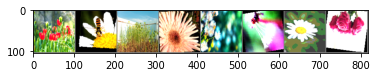

tulip daisy sunflower daisy dandelion dandelion daisy rose 


In [8]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(484 * 4 * 4, 8)
        self.fc2 = nn.Linear(8, 100)
        self.fc3 = nn.Linear(100, 64)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.8f}')
            running_loss = 0.0

print('Finished Training')

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[1,   500] loss: 1.84403214
[1,  1000] loss: 1.37983036
[1,  1500] loss: 1.27864107
[1,  2000] loss: 1.23321580
[1,  2500] loss: 1.18486039
[1,  3000] loss: 1.13416554


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[2,   500] loss: 1.08075494
[2,  1000] loss: 1.07529176
[2,  1500] loss: 1.01239003
[2,  2000] loss: 0.97409930
[2,  2500] loss: 0.96631139
[2,  3000] loss: 0.97674185


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[3,   500] loss: 0.89673871
[3,  1000] loss: 0.91382285
[3,  1500] loss: 0.93031741
[3,  2000] loss: 0.89298779
[3,  2500] loss: 0.90438233
[3,  3000] loss: 0.89576516


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[4,   500] loss: 0.82675527
[4,  1000] loss: 0.87337168
[4,  1500] loss: 0.85131655
[4,  2000] loss: 0.85344514
[4,  2500] loss: 0.81921356
[4,  3000] loss: 0.81761158


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[5,   500] loss: 0.77153059
[5,  1000] loss: 0.80310961
[5,  1500] loss: 0.78062698
[5,  2000] loss: 0.79338276
[5,  2500] loss: 0.80409932
[5,  3000] loss: 0.79116661


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[6,   500] loss: 0.73168661
[6,  1000] loss: 0.76853137
[6,  1500] loss: 0.76500555
[6,  2000] loss: 0.77069253
[6,  2500] loss: 0.76918722
[6,  3000] loss: 0.77570113


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[7,   500] loss: 0.73799627
[7,  1000] loss: 0.73416742
[7,  1500] loss: 0.71335378
[7,  2000] loss: 0.74901989
[7,  2500] loss: 0.72071251
[7,  3000] loss: 0.71446019


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[8,   500] loss: 0.69396792
[8,  1000] loss: 0.71235248
[8,  1500] loss: 0.73452408
[8,  2000] loss: 0.69678606
[8,  2500] loss: 0.71918999
[8,  3000] loss: 0.71330570


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[9,   500] loss: 0.65896186
[9,  1000] loss: 0.66365949
[9,  1500] loss: 0.71615110
[9,  2000] loss: 0.71366054
[9,  2500] loss: 0.70736798
[9,  3000] loss: 0.68183265


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[10,   500] loss: 0.67660781
[10,  1000] loss: 0.67441421
[10,  1500] loss: 0.66938599
[10,  2000] loss: 0.66782169
[10,  2500] loss: 0.68124677
[10,  3000] loss: 0.68656577


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[11,   500] loss: 0.65839361
[11,  1000] loss: 0.67462193
[11,  1500] loss: 0.64479774
[11,  2000] loss: 0.65560059
[11,  2500] loss: 0.67140241
[11,  3000] loss: 0.66480192


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[12,   500] loss: 0.64815810
[12,  1000] loss: 0.62751139
[12,  1500] loss: 0.64423879
[12,  2000] loss: 0.64145496
[12,  2500] loss: 0.67954507
[12,  3000] loss: 0.63716744


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[13,   500] loss: 0.64942615
[13,  1000] loss: 0.65120878
[13,  1500] loss: 0.63336178
[13,  2000] loss: 0.64363932
[13,  2500] loss: 0.65103618
[13,  3000] loss: 0.63236603


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[14,   500] loss: 0.65267837
[14,  1000] loss: 0.60927146
[14,  1500] loss: 0.60651395
[14,  2000] loss: 0.65594686
[14,  2500] loss: 0.65095698
[14,  3000] loss: 0.65507658


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[15,   500] loss: 0.62612060
[15,  1000] loss: 0.62419785
[15,  1500] loss: 0.60537768
[15,  2000] loss: 0.61199224
[15,  2500] loss: 0.61727617
[15,  3000] loss: 0.61831372


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[16,   500] loss: 0.61538867
[16,  1000] loss: 0.62582834
[16,  1500] loss: 0.59944700
[16,  2000] loss: 0.59429397
[16,  2500] loss: 0.60472018
[16,  3000] loss: 0.60284481


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[17,   500] loss: 0.60523784
[17,  1000] loss: 0.59700338
[17,  1500] loss: 0.61076249
[17,  2000] loss: 0.63749964
[17,  2500] loss: 0.59121103
[17,  3000] loss: 0.59730076


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[18,   500] loss: 0.60797538
[18,  1000] loss: 0.61047372
[18,  1500] loss: 0.61966409
[18,  2000] loss: 0.60476440
[18,  2500] loss: 0.59226633
[18,  3000] loss: 0.59346468


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[19,   500] loss: 0.58839962
[19,  1000] loss: 0.57570316
[19,  1500] loss: 0.61118087
[19,  2000] loss: 0.59423428
[19,  2500] loss: 0.62164449
[19,  3000] loss: 0.59852905


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[20,   500] loss: 0.57050716
[20,  1000] loss: 0.59337625
[20,  1500] loss: 0.59191096
[20,  2000] loss: 0.59038216
[20,  2500] loss: 0.59155838
[20,  3000] loss: 0.62693678


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[21,   500] loss: 0.58492301
[21,  1000] loss: 0.58824459
[21,  1500] loss: 0.56327129
[21,  2000] loss: 0.58912427
[21,  2500] loss: 0.59995558
[21,  3000] loss: 0.59339940


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[22,   500] loss: 0.56945168
[22,  1000] loss: 0.61034183
[22,  1500] loss: 0.58173591
[22,  2000] loss: 0.57481163
[22,  2500] loss: 0.59483376
[22,  3000] loss: 0.56949116


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[23,   500] loss: 0.56242943
[23,  1000] loss: 0.55416618
[23,  1500] loss: 0.57057101
[23,  2000] loss: 0.58382033
[23,  2500] loss: 0.56480909
[23,  3000] loss: 0.57611720


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[24,   500] loss: 0.55380998
[24,  1000] loss: 0.56746958
[24,  1500] loss: 0.56435038
[24,  2000] loss: 0.54629346
[24,  2500] loss: 0.57773155
[24,  3000] loss: 0.57843158


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[25,   500] loss: 0.56642012
[25,  1000] loss: 0.56634008
[25,  1500] loss: 0.56553229
[25,  2000] loss: 0.60261346
[25,  2500] loss: 0.57373687
[25,  3000] loss: 0.57498157


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[26,   500] loss: 0.56788164
[26,  1000] loss: 0.57731806
[26,  1500] loss: 0.56098889
[26,  2000] loss: 0.59355830
[26,  2500] loss: 0.54444749
[26,  3000] loss: 0.56833383


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[27,   500] loss: 0.54807828
[27,  1000] loss: 0.53775123
[27,  1500] loss: 0.55662481
[27,  2000] loss: 0.56997764
[27,  2500] loss: 0.55332885
[27,  3000] loss: 0.57841084


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[28,   500] loss: 0.55161873
[28,  1000] loss: 0.55164870
[28,  1500] loss: 0.56853712
[28,  2000] loss: 0.56582935
[28,  2500] loss: 0.58016012
[28,  3000] loss: 0.55331820


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[29,   500] loss: 0.56634846
[29,  1000] loss: 0.55747768
[29,  1500] loss: 0.57298227
[29,  2000] loss: 0.55783222
[29,  2500] loss: 0.55848677
[29,  3000] loss: 0.54254205


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[30,   500] loss: 0.55444402
[30,  1000] loss: 0.57691060
[30,  1500] loss: 0.51441927
[30,  2000] loss: 0.54868711
[30,  2500] loss: 0.57165640
[30,  3000] loss: 0.55521337


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[31,   500] loss: 0.53266335
[31,  1000] loss: 0.54793814
[31,  1500] loss: 0.53568955
[31,  2000] loss: 0.54652435
[31,  2500] loss: 0.55801361
[31,  3000] loss: 0.56732055


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[32,   500] loss: 0.53174003
[32,  1000] loss: 0.55389141
[32,  1500] loss: 0.53897020
[32,  2000] loss: 0.55320871
[32,  2500] loss: 0.52238995
[32,  3000] loss: 0.58100828


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[33,   500] loss: 0.53007156
[33,  1000] loss: 0.53769934
[33,  1500] loss: 0.55413320
[33,  2000] loss: 0.54196998
[33,  2500] loss: 0.55094322
[33,  3000] loss: 0.53520685


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[34,   500] loss: 0.54843243
[34,  1000] loss: 0.55270875
[34,  1500] loss: 0.56358100
[34,  2000] loss: 0.52499373
[34,  2500] loss: 0.54631884
[34,  3000] loss: 0.53203586


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[35,   500] loss: 0.53677407
[35,  1000] loss: 0.55025676
[35,  1500] loss: 0.53634341
[35,  2000] loss: 0.51528837
[35,  2500] loss: 0.54184581
[35,  3000] loss: 0.54480714


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[36,   500] loss: 0.53038389
[36,  1000] loss: 0.54408092
[36,  1500] loss: 0.54293685
[36,  2000] loss: 0.53354485
[36,  2500] loss: 0.54800848
[36,  3000] loss: 0.52371417


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[37,   500] loss: 0.55310626
[37,  1000] loss: 0.53201404
[37,  1500] loss: 0.51409397
[37,  2000] loss: 0.54017907
[37,  2500] loss: 0.55631463
[37,  3000] loss: 0.51828490


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[38,   500] loss: 0.54541670
[38,  1000] loss: 0.54247954
[38,  1500] loss: 0.52455958
[38,  2000] loss: 0.54801678
[38,  2500] loss: 0.53266373
[38,  3000] loss: 0.52658112


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[39,   500] loss: 0.53907834
[39,  1000] loss: 0.53375137
[39,  1500] loss: 0.52649189
[39,  2000] loss: 0.54836141
[39,  2500] loss: 0.53825349
[39,  3000] loss: 0.54750663


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[40,   500] loss: 0.52673475
[40,  1000] loss: 0.52346196
[40,  1500] loss: 0.51088407
[40,  2000] loss: 0.55960490
[40,  2500] loss: 0.54168605
[40,  3000] loss: 0.54868362


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[41,   500] loss: 0.53118453
[41,  1000] loss: 0.52257224
[41,  1500] loss: 0.51856404
[41,  2000] loss: 0.54082116
[41,  2500] loss: 0.53440658
[41,  3000] loss: 0.52571361


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[42,   500] loss: 0.52738180
[42,  1000] loss: 0.51732544
[42,  1500] loss: 0.52749435
[42,  2000] loss: 0.53514318
[42,  2500] loss: 0.52080573
[42,  3000] loss: 0.50365255


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[43,   500] loss: 0.54350490
[43,  1000] loss: 0.53210302
[43,  1500] loss: 0.53258276
[43,  2000] loss: 0.52516359
[43,  2500] loss: 0.53081765
[43,  3000] loss: 0.50304418


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[44,   500] loss: 0.53789704
[44,  1000] loss: 0.52934397
[44,  1500] loss: 0.52811330
[44,  2000] loss: 0.50964014
[44,  2500] loss: 0.50086520
[44,  3000] loss: 0.52350570


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[45,   500] loss: 0.50953301
[45,  1000] loss: 0.51916894
[45,  1500] loss: 0.52346615
[45,  2000] loss: 0.52464131
[45,  2500] loss: 0.51889685
[45,  3000] loss: 0.51467515


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[46,   500] loss: 0.52851412
[46,  1000] loss: 0.53976511
[46,  1500] loss: 0.53528119
[46,  2000] loss: 0.51478689
[46,  2500] loss: 0.50415187
[46,  3000] loss: 0.52797574


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[47,   500] loss: 0.54275191
[47,  1000] loss: 0.51549800
[47,  1500] loss: 0.51769203
[47,  2000] loss: 0.51308708
[47,  2500] loss: 0.53663036
[47,  3000] loss: 0.54795977


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[48,   500] loss: 0.51168461
[48,  1000] loss: 0.50130710
[48,  1500] loss: 0.51813339
[48,  2000] loss: 0.51559071
[48,  2500] loss: 0.54208523
[48,  3000] loss: 0.53138187


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[49,   500] loss: 0.50866702
[49,  1000] loss: 0.50878129
[49,  1500] loss: 0.54549811
[49,  2000] loss: 0.53030789
[49,  2500] loss: 0.51643522
[49,  3000] loss: 0.53871429


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: User

[50,   500] loss: 0.53012378
[50,  1000] loss: 0.50479143
[50,  1500] loss: 0.51040234
[50,  2000] loss: 0.53029759
[50,  2500] loss: 0.52714002
[50,  3000] loss: 0.52303370
Finished Training


Note of training process:   
* An Epoch of 100 was used to find where pay off of running additional testing runs out. The computation time was excuriatingly long.   Approximately 70 mins to run on kaggle.com.
* * * EXPANSION IDEA ATTEMPT: Will run with 1000 tests over night for curiosity 
* This made me settle on 30 for the epoch as 26 was the first to reach 0.000 loss as a means to shorten future training times(eliminate waste time).
* *     ERROR FOUND IN ABOVE STATEMENT: I realized after the fact that my running_loss was still being divided by 2000, instead of 200 in the EPOCH of 100 output.
* Results print out in markdown below for historical tracking.
* * FUTURE IMPROVEMENT: These loss outputs is what should be graphed with Auto....

* *     ERROR PRESENT IN CODE: I realized after the fact that my running_loss was still being divided by 2000, instead of 200. ALL LOSS VALUES times 10 in value.
RESULTS of EPOCH 100:
* [1,   200] loss: 0.173
* [1,   400] loss: 0.162
* [2,   200] loss: 0.151
* [2,   400] loss: 0.145
* [3,   200] loss: 0.141
* [3,   400] loss: 0.139
* [4,   200] loss: 0.135
* [4,   400] loss: 0.136
* [5,   200] loss: 0.130
* [5,   400] loss: 0.130
* [6,   200] loss: 0.125
* [6,   400] loss: 0.125
* [7,   200] loss: 0.119
* [7,   400] loss: 0.120
* [8,   200] loss: 0.110
* [8,   400] loss: 0.112
* [9,   200] loss: 0.097
* [9,   400] loss: 0.087
* [10,   200] loss: 0.069
* [10,   400] loss: 0.070
* [11,   200] loss: 0.040
* [11,   400] loss: 0.053
* [12,   200] loss: 0.027
* [12,   400] loss: 0.032
* [13,   200] loss: 0.017
* [13,   400] loss: 0.021
* [14,   200] loss: 0.011
* [14,   400] loss: 0.014
* [15,   200] loss: 0.010
* [15,   400] loss: 0.009
* [16,   200] loss: 0.009
* [16,   400] loss: 0.005
* [17,   200] loss: 0.006
* [17,   400] loss: 0.005
* [18,   200] loss: 0.003
* [18,   400] loss: 0.008
* [19,   200] loss: 0.006
* [19,   400] loss: 0.005
* [20,   200] loss: 0.005
* [20,   400] loss: 0.004
* [21,   200] loss: 0.008
* [21,   400] loss: 0.005
* [22,   200] loss: 0.004
* [22,   400] loss: 0.007
* [23,   200] loss: 0.002
* [23,   400] loss: 0.005
* [24,   200] loss: 0.002
* [24,   400] loss: 0.004
* [25,   200] loss: 0.002
* [25,   400] loss: 0.003
* [26,   200] loss: 0.001
* [26,   400] loss: 0.000
* [27,   200] loss: 0.000     <------------
* [27,   400] loss: 0.001
* [28,   200] loss: 0.001
* [28,   400] loss: 0.001
* [29,   200] loss: 0.000
* [29,   400] loss: 0.000
* [30,   200] loss: 0.001
* [30,   400] loss: 0.000
* [31,   200] loss: 0.001
* [31,   400] loss: 0.000
* [32,   200] loss: 0.000
* [32,   400] loss: 0.000
* [33,   200] loss: 0.000
* [33,   400] loss: 0.001
* [34,   200] loss: 0.000
* [34,   400] loss: 0.000
* [35,   200] loss: 0.000
* [35,   400] loss: 0.000
* [36,   200] loss: 0.000
* [36,   400] loss: 0.000
* [37,   200] loss: 0.000
* [37,   400] loss: 0.000
* [38,   200] loss: 0.000
* [38,   400] loss: 0.001
* [39,   200] loss: 0.000
* [39,   400] loss: 0.000
* [40,   200] loss: 0.000
* [40,   400] loss: 0.000
* [41,   200] loss: 0.000
* [41,   400] loss: 0.000
* [42,   200] loss: 0.000
* [42,   400] loss: 0.000
* [43,   200] loss: 0.000
* [43,   400] loss: 0.000
* [44,   200] loss: 0.000
* [44,   400] loss: 0.000
* [45,   200] loss: 0.000
* [45,   400] loss: 0.000
* [46,   200] loss: 0.000
* [46,   400] loss: 0.000
* [47,   200] loss: 0.000
* [47,   400] loss: 0.000
* [48,   200] loss: 0.000
* [48,   400] loss: 0.000
* [49,   200] loss: 0.000
* [49,   400] loss: 0.000
* [50,   200] loss: 0.000
* [50,   400] loss: 0.001
* [51,   200] loss: 0.000
* [51,   400] loss: 0.000
* [52,   200] loss: 0.000
* [52,   400] loss: 0.000
* [53,   200] loss: 0.000
* [53,   400] loss: 0.000
* [54,   200] loss: 0.000
* [54,   400] loss: 0.000
* [55,   200] loss: 0.000
* [55,   400] loss: 0.000
* [56,   200] loss: 0.000
* [56,   400] loss: 0.000
* [57,   200] loss: 0.000
* [57,   400] loss: 0.000
* [58,   200] loss: 0.000
* [58,   400] loss: 0.000
* [59,   200] loss: 0.000
* [59,   400] loss: 0.000
* [60,   200] loss: 0.000
* [60,   400] loss: 0.000
* [61,   200] loss: 0.000
* [61,   400] loss: 0.000
* [62,   200] loss: 0.000
* [62,   400] loss: 0.000
* [63,   200] loss: 0.000
* [63,   400] loss: 0.000
* [64,   200] loss: 0.000
* [64,   400] loss: 0.000
* [65,   200] loss: 0.000
* [65,   400] loss: 0.000
* [66,   200] loss: 0.000
* [66,   400] loss: 0.000
* [67,   200] loss: 0.000
* [67,   400] loss: 0.000
* [68,   200] loss: 0.000
* [68,   400] loss: 0.000
* [69,   200] loss: 0.000
* [69,   400] loss: 0.000
* [70,   200] loss: 0.000
* [70,   400] loss: 0.000
* [71,   200] loss: 0.000
* [71,   400] loss: 0.000
* [72,   200] loss: 0.000
* [72,   400] loss: 0.000
* [73,   200] loss: 0.000
* [73,   400] loss: 0.000
* [74,   200] loss: 0.000
* [74,   400] loss: 0.000
* [75,   200] loss: 0.000
* [75,   400] loss: 0.000
* [76,   200] loss: 0.000
* [76,   400] loss: 0.000
* [77,   200] loss: 0.000
* [77,   400] loss: 0.000
* [78,   200] loss: 0.000
* [78,   400] loss: 0.000
* [79,   200] loss: 0.000
* [79,   400] loss: 0.000
* [80,   200] loss: 0.000
* [80,   400] loss: 0.000
* [81,   200] loss: 0.000
* [81,   400] loss: 0.000
* [82,   200] loss: 0.000
* [82,   400] loss: 0.000
* [83,   200] loss: 0.000
* [83,   400] loss: 0.000
* [84,   200] loss: 0.000
* [84,   400] loss: 0.000
* [85,   200] loss: 0.000
* [85,   400] loss: 0.000
* [86,   200] loss: 0.000
* [86,   400] loss: 0.000
* [87,   200] loss: 0.000
* [87,   400] loss: 0.000
* [88,   200] loss: 0.000
* [88,   400] loss: 0.000
* [89,   200] loss: 0.000
* [89,   400] loss: 0.000
* [90,   200] loss: 0.000
* [90,   400] loss: 0.000
* [91,   200] loss: 0.000
* [91,   400] loss: 0.000
* [92,   200] loss: 0.000
* [92,   400] loss: 0.000
* [93,   200] loss: 0.000
* [93,   400] loss: 0.000
* [94,   200] loss: 0.000
* [94,   400] loss: 0.000
* [95,   200] loss: 0.000
* [95,   400] loss: 0.000
* [96,   200] loss: 0.000
* [96,   400] loss: 0.000
* [97,   200] loss: 0.000
* [97,   400] loss: 0.000
* [98,   200] loss: 0.000
* [98,   400] loss: 0.000
* [99,   200] loss: 0.000
* [99,   400] loss: 0.000
* [100,   200] loss: 0.000
* [100,   400] loss: 0.000
* Finished Training


In [12]:
PATH = './flowers.pth'
torch.save(net.state_dict(), PATH)

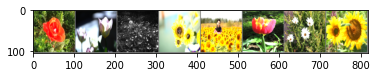

GroundTruth:  rose 


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(1)))

In [14]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [15]:
outputs = net(images)

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(1)))

Predicted:  rose 


In [17]:
correct = 0
total = 0

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in devloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predictions = torch.max(outputs, 1)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(f'Accuracy of the network on the { total } dev images: {100 * correct // total} %')

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Dev Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 864 dev images: 98 %
Dev Accuracy for class: daisy is 98.7 %
Dev Accuracy for class: dandelion is 99.5 %
Dev Accuracy for class: rose  is 98.8 %
Dev Accuracy for class: sunflower is 98.6 %
Dev Accuracy for class: tulip is 98.5 %


In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

correct = 0
total = 0
# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


print(f'Accuracy of the network on the { total } test images: {100 * correct // total} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Test Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 1080 test images: 97 %
Test Accuracy for class: daisy is 97.1 %
Test Accuracy for class: dandelion is 99.3 %
Test Accuracy for class: rose  is 96.6 %
Test Accuracy for class: sunflower is 95.1 %
Test Accuracy for class: tulip is 96.2 %


BLEW AWAY MY LAST ONE!!!!
Accuracy of the network on the 1080 test images: 98 %
Test Accuracy for class: daisy is 99.0 %
Test Accuracy for class: dandelion is 99.6 %
Test Accuracy for class: rose  is 98.3 %
Test Accuracy for class: sunflower is 98.9 %
Test Accuracy for class: tulip is 95.4 %


Best Results yet!
Accuracy of the network on the 1080 test images: 80 %
Test Accuracy for class: daisy is 84.8 %
Test Accuracy for class: dandelion is 80.2 %
Test Accuracy for class: rose  is 60.7 %
Test Accuracy for class: sunflower is 89.7 %
Test Accuracy for class: tulip is 84.9 %

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [20]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=7744, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=64, bias=True)
)

In [21]:
inputs, labels = data[0].to(device), data[1].to(device)